In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

import re
import seaborn as sns
import datetime
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

Load data.

- Station Data
- Cleaned data of bike trips
- Cleaned data of YVR weather data

In [2]:
data_folder = 'data'
pickle_folder = 'pickle'

#load station data
station_info_df = pd.read_csv(data_folder + '/' + 'station_data.csv', dtype={'id': str, 'name': str, 'lat': float, 'lon': float, 'total_slots':int})

def load_pickle(url):
    '''
    Function to load pickle file
    '''
    infile = open(url, 'rb')
    data = pickle.load(infile)
    infile.close()
    return data

filename = 'mobi_cleaned.pkl'
combined_df = load_pickle(pickle_folder + '/' + filename)

filename = 'YVR_wxdata.pkl'
weather_df = load_pickle(pickle_folder + '/' + filename)   

###  Start of DF assembly

In [3]:
date_range_ind = pd.date_range(start=datetime.date(2017, 1, 1), end=datetime.date(2019, 3, 31), freq='D')

In [4]:
def average_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).sum()/target_df.resample(time_freq).count()
    
    return(output_target_df)


def max_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).max()
       
    return(output_target_df)


def min_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).min()

    return(output_target_df)


def sum_df(colname, df, time_freq='D'):
    '''
    Function to calculate the average based on the time frequency.
    '''
    
    target_df = df[colname]
    target_df.index = df['Date']

    output_target_df = target_df.resample(time_freq).sum()
    return(output_target_df)

In [5]:
df = pd.DataFrame({'count': [1] * len(combined_df['Departure'])})
df.index = combined_df['Departure']

df = df.resample('D').count()
#df['AVG_TEMP'] = temp_daily_avg_df
df = df[:-1]

var_list = ['CO', 'NO', 'NO2', 'O3', 'PM25', 'SO2', 'PM10', 'WSPD_SCLR',
       'WDIR_SCLR', 'WSPD_VECT', 'WDIR_VECT', 'TEMP_MEAN', 'ATM_PRESS_1HR',
       'HUMIDITY', 'RAD_TOTAL', 'PRECIP_TOTAL']

for var in var_list:
    df[('AVG_'+var)] = average_df(var, weather_df)

for var in ['TEMP_MEAN']:
    df[('MAX_'+var)] = max_df(var, weather_df)
    
for var in ['TEMP_MEAN']:
    df[('MIN_'+var)] = min_df(var, weather_df)

df['SUM_PRECIP_TOTAL'] = sum_df('PRECIP_TOTAL', weather_df)

### Plotting the Correlation Matrix

First scale the data before doing the correlation matrix, or else it will be skewed.

The variables that are highly correlated to the trip counts in a day is the average temperature and the average solar irradiance. There is a theoretical equation in which the total and average solar irradiance can be calcuated, but this variables fluctuates with cloud cover and aerosol concentration in the air. 

From a practical perspective, temperature and precipitation are the only variables where we can reasonable rely on if we want to use forecast data from a weather model. 

For this project, I am going to make an assumption that the observation model that we use for the testing and validation are the same as the forecast data that is generated from a weather model. Usually, the data from a weather model that are 2-3 days out are quite reliable.

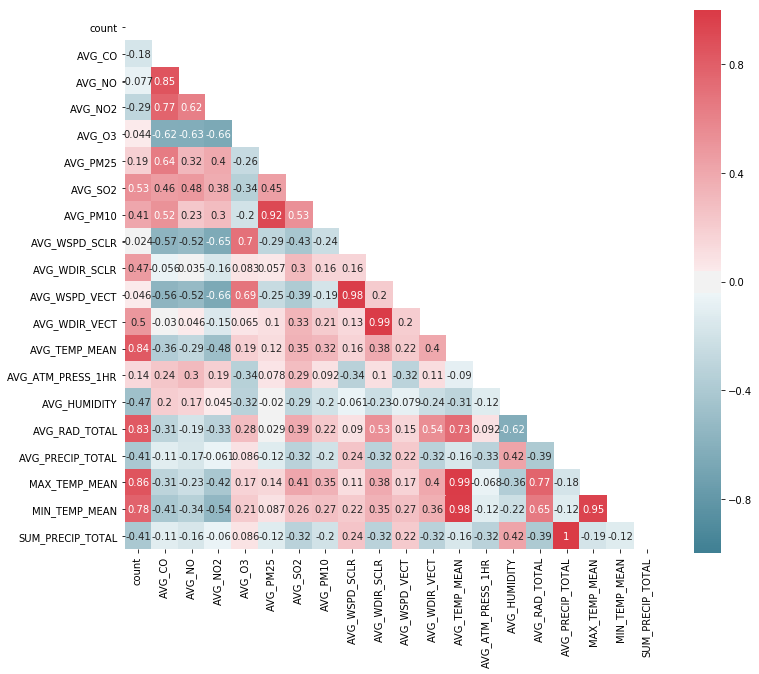

In [6]:
from sklearn.preprocessing import StandardScaler

def scale_data(df):
    scaler = StandardScaler()
    scaler.fit(df)
    scaled_df = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_df, columns=df.columns, index=df.index)
    return(scaled_df)

#scaled_df = scale_data(df)

plt.figure(figsize=(12,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

corr_df = scale_data(df).corr()

mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_df, mask = mask, annot=True, cmap=cmap, center=0, vmin=-1.0, vmax=1.0, square=True);

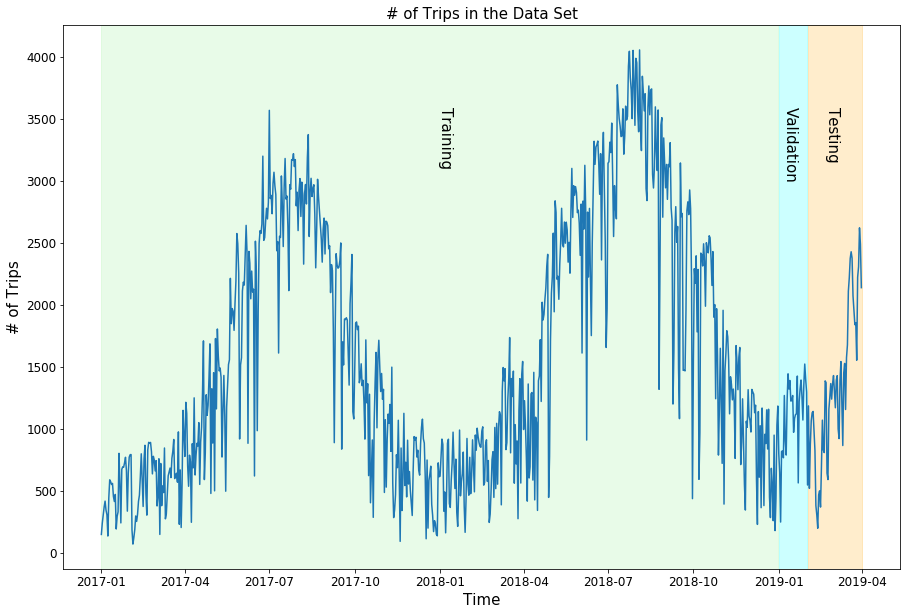

In [7]:
col = 'black'
a = 0.2
font_size_tick=12
plt.figure(figsize=(15,10))
plt.plot(df['count'], label='Count')
plt.xlabel('Time', fontsize=15, color=col)
plt.ylabel('# of Trips', fontsize=15, color=col)
plt.title('# of Trips in the Data Set',  fontsize=15, color=col)
plt.xticks(fontsize=font_size_tick, color=col)
plt.yticks(fontsize=font_size_tick, color=col)
plt.axvspan('2017-01-01', '2018-12-31', color='lightgreen', alpha=a)
plt.axvspan('2019-01-01', '2019-01-31', color='cyan', alpha=a)
plt.axvspan('2019-02-01', '2019-04-01', color='orange', alpha=a)
plt.annotate('Training', ('2017-12-30', 3500), fontsize=15, rotation=270)
plt.annotate('Validation', ('2019-01-05', 3500), fontsize=15, rotation=270)
plt.annotate('Testing', ('2019-02-20', 3500), fontsize=15, rotation=270)
plt.show();

### Adding Additional Features

#### Day of the Week

In [8]:
df['day_of_week']=df.index.to_series().dt.dayofweek

df.loc[df['day_of_week'] == 0, 'day_of_week'] = 'Monday'
df.loc[df['day_of_week'] == 1, 'day_of_week'] = 'Tuesday'
df.loc[df['day_of_week'] == 2, 'day_of_week'] = 'Wednesday'
df.loc[df['day_of_week'] == 3, 'day_of_week'] = 'Thursday'
df.loc[df['day_of_week'] == 4, 'day_of_week'] = 'Friday'
df.loc[df['day_of_week'] == 5, 'day_of_week'] = 'Saturday'
df.loc[df['day_of_week'] == 6, 'day_of_week'] = 'Sunday'

#### Holidays in BC

In [9]:
holiday_list = [datetime.datetime(2017, 1, 1),
    datetime.datetime(2017, 1, 2),
    datetime.datetime(2017, 2, 13),
    datetime.datetime(2017, 4, 14),
    datetime.datetime(2017, 5, 22),
    datetime.datetime(2017, 7, 1),
    datetime.datetime(2017, 8, 7),
    datetime.datetime(2017, 9, 4),
    datetime.datetime(2017, 10, 9),
    datetime.datetime(2017, 11, 10),
    datetime.datetime(2017, 11, 11),
    datetime.datetime(2017, 12, 24),
    datetime.datetime(2017, 12, 25),
    datetime.datetime(2017, 12, 26),
    datetime.datetime(2018, 1, 1),
    datetime.datetime(2018, 2, 12),
    datetime.datetime(2018, 3, 30),
    datetime.datetime(2018, 5, 21),
    datetime.datetime(2018, 7, 1),
    datetime.datetime(2018, 7, 2),
    datetime.datetime(2018, 8, 6),
    datetime.datetime(2018, 9, 3),
    datetime.datetime(2018, 10, 8),
    datetime.datetime(2018, 11, 11),
    datetime.datetime(2018, 11, 12),
    datetime.datetime(2018, 12, 24),
    datetime.datetime(2018, 12, 25),
    datetime.datetime(2018, 12, 26),
    datetime.datetime(2019, 1, 1),
    datetime.datetime(2019, 2, 18)
]
holiday_list = pd.to_datetime(holiday_list)

#convert to 1 and 0
holiday_col = date_range_ind.isin(holiday_list)

df['HOLIDAY'] = holiday_col.astype(int)
df['NOT_HOLIDAY'] = (~(holiday_col)).astype(int)

del holiday_list, holiday_col

#### Add Season

In [10]:
#from stack overflow
#https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime

def season_of_date(date):
    year = str(date.year)
    seasons = {'Spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'Summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'Autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['Spring']:
        return 'Spring'
    if date in seasons['Summer']:
        return 'Summer'
    if date in seasons['Autumn']:
        return 'Autumn'
    else:
        return 'Winter'
    
df['SEASON'] = date_range_ind.map(season_of_date)

#### Add Quarter, Weekday, Weekend


In [11]:
df['QUARTER'] = date_range_ind.quarter.astype(str)

df['Weekday'] = df['day_of_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']).astype(int)
df['Weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

#### Functions for model analysis 

In [12]:
def custom_predict(model, X_train, X_valid, X_test, y_scaler=None):
    '''
    Uses the predict method for a model on the train valid and test set.
    '''
    
    X_list = [X_train, X_valid, X_test]
    y_pred_list = []
    
    for i in range(0,3):
        
        y_pred = model.predict(X_list[i])
        
        #For Neural networks
        if y_scaler is not None:
            y_pred = y_scaler.inverse_transform(y_pred)
        
        y_pred_list.append(y_pred)
            
    return y_pred_list

def custom_model_score(y_pred_list, y_train, y_valid, y_test):
    '''
    Calculates the RMSE and R2 metrics
    '''
    
    import math
    from sklearn.metrics import r2_score, mean_squared_error
   
    score_output = [
        math.sqrt(mean_squared_error(y_train, y_pred_list[0].round())),
        math.sqrt(mean_squared_error(y_valid, y_pred_list[1].round())),
        math.sqrt(mean_squared_error(y_test, y_pred_list[2].round())),
        r2_score(y_train, y_pred_list[0].round()),
        r2_score(y_valid, y_pred_list[1].round()),
        r2_score(y_test, y_pred_list[2].round())
        ]
    
    return (score_output)

def custom_score_display(the_score, index=None):
    
    '''
    If a list of index is provided, it will expect the first argument to be a list to create a combined score.
    '''

    if index is None:
        output_score  = pd.DataFrame([the_score])
    else:
        output_score = pd.DataFrame(the_score)
        output_score.index = index
    
    output_score.columns = ['Training - RMSE', 'Validation - RMSE', 'Test - RMSE', 'Training - R2', 'Valid - R2', 'Test - R2']
    
    return (output_score)

def custom_plot_package(model_name, y_pred_list, y_train, y_valid, y_test):

    '''
    Outputs plots for train, valid, and test
    
    In addition, it calls the model_score function that calculates the RMSE and R2
    '''

    name_list = ['Training', 'Validation', 'Test']
    y_list = [y_train, y_valid, y_test]
    
    plt.figure(figsize=(12,12))
    for i in range(3):
        plt.subplot(3,1, (i + 1))
        plt.plot(y_list[i], label='Actual')
        plt.plot(pd.DataFrame(y_pred_list[i], index=y_list[i].index), label='Prediction')
        plt.legend()
        plt.title(model_name + ' - ' + name_list[i])
        plt.xlim(y_list[i].index[0], y_list[i].index[-1])

    return None


def custom_tvt_split(Xy, date_range_train, date_range_valid, date_range_test):
    '''
    Wrapper function to split into train, valid, and test
    '''
    
    Xy_train = Xy.loc[date_range_train]
    Xy_test = Xy.loc[date_range_test]
    Xy_valid = Xy.loc[date_range_valid]
    
    return Xy_train, Xy_valid, Xy_test

### Assemble DataFrame

The features that I will be using can be split into two categories. Weather and Time features.

Weather Features:
- Average Temperature - There is a higher correlation with the daily bike count due to seasonality.
- Max Temperature
- Min Temperature
- Sum of Precipitation - When this feature is included, it helps with accounting for the daily fluctuations.

Time Features
- Day of the Week
- Holiday or Not a Holiday
- Season
- Quarter
- Weekday
- Weekend


In [13]:
X = df.reindex(['AVG_TEMP_MEAN', 'day_of_week', 'SUM_PRECIP_TOTAL', 'MAX_TEMP_MEAN', 'MIN_TEMP_MEAN',
                'HOLIDAY', 'NOT_HOLIDAY', 'SEASON', 'QUARTER', 'Weekday', 'Weekend'], axis=1)

y = df['count']

In [14]:
date_range_train = pd.date_range(start=datetime.date(2017, 1, 1), end=datetime.date(2018, 12, 31), freq='D')
date_range_valid = pd.date_range(start=datetime.date(2019, 1, 1), end=datetime.date(2019, 1, 31), freq='D')
date_range_test = pd.date_range(start=datetime.date(2019, 2, 1), end=datetime.date(2019, 3, 31), freq='D')

X_onehot = pd.get_dummies(X)
X_train, X_valid,  X_test = custom_tvt_split(X_onehot, date_range_train, date_range_valid, date_range_test)

y_train, y_valid,  y_test = custom_tvt_split(y, date_range_train, date_range_valid, date_range_test)

#For Statsmodel OLS
import statsmodels.api as sm
X_onehot_c = sm.add_constant(X_onehot)
X_train_c, X_valid_c,  X_test_c = custom_tvt_split(X_onehot_c, date_range_train, date_range_valid, date_range_test)

In [15]:
from statsmodels.regression import linear_model

lin_reg_model_sm = linear_model.OLS(y_train, X_train_c).fit()
lin_reg_model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     230.7
Date:                Tue, 03 Sep 2019   Prob (F-statistic):          7.51e-276
Time:                        14:26:26   Log-Likelihood:                -5418.3
No. Observations:                 730   AIC:                         1.087e+04
Df Residuals:                     712   BIC:                         1.096e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    89.3768     27.679      3.229      0.001      35.034     143.719
AVG_TEMP_MEAN           160.2056     45.364      3.532      0.000      71.142     249.269
SUM_PRECIP_TOTAL        -30.2747      2.159    -14.022      0.000     -34.513     -26.036
MAX_TEMP_MEAN            51.9079     24.315      2.135      0.033       4.170      99.646
MIN_TEMP_MEAN          -123.3256     23.920     -5.156      0.000    -170.288     -76.364
HOLIDAY                  17.5973     50.072      0.351      0.725     -80.710     115.904
NOT_HOLIDAY              71.7795     37.284      1.925      0.055      -1.421     144.980
Weekday                 104.2826     19.296      5.404      0.000      66.399     142.166
Weekend                 -14.9057     17.968     -0.830      0.407     -50.183      20.371
day_of_week_Friday       50.6270     36.198      1.399      0.162     -20.440     121.694
day_of_week_Monday      -35.5753     36.891     -0.964      0.335    -108.003      36.852
day_of_week_Saturday     72.4028     29.772      2.432      0.015      13.952     130.854
day_of_week_Sunday      -87.3085     29.813     -2.929      0.004    -145.840     -28.777
day_of_week_Thursday     53.8860     36.646      1.470      0.142     -18.062     125.834
day_of_week_Tuesday      30.6977     36.436      0.843      0.400     -40.837     102.233
day_of_week_Wednesday     4.6472     36.382      0.128      0.898     -66.782      76.076
SEASON_Autumn             7.9719     57.795      0.138      0.890    -105.497     121.441
SEASON_Spring          -141.6792     53.857     -2.631      0.009    -247.417     -35.942
SEASON_Summer           331.6684     62.950      5.269      0.000     208.079     455.258
SEASON_Winter          -108.5842     55.525     -1.956      0.051    -217.597       0.428
QUARTER_1              -111.2705     54.350     -2.047      0.041    -217.976      -4.565
QUARTER_2               100.4451     57.371      1.751      0.080     -12.191     213.081
QUARTER_3               104.8765     60.937      1.721      0.086     -14.762     224.515
QUARTER_4                -4.6743     57.580     -0.081      0.935    -117.720     108.372
==============================================================================
Omnibus:                        2.327   Durbin-Watson:                   0.876
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                2.309
Skew:                           0.138   Prob(JB):                        0.315
Kurtosis:                       2.983   Cond. No.                     5.21e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.34e-30. This might indicate that there are


,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,404.757259,421.274793,558.745766,0.846386,-1.003925,0.175153


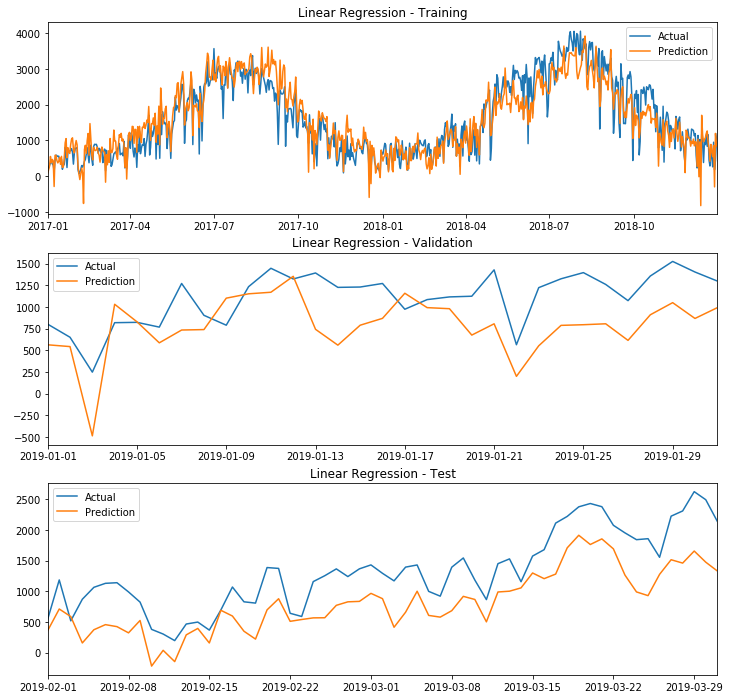

In [16]:
lin_y_pred_list = custom_predict(lin_reg_model_sm, X_train_c, X_valid_c, X_test_c, y_scaler=None)
lin_score = custom_model_score(lin_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(lin_score))
custom_plot_package('Linear Regression', lin_y_pred_list, y_train, y_valid, y_test)

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor

RF_model = RandomForestRegressor(n_estimators=50, max_depth=10, oob_score=False, n_jobs=-1)
RF_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,186.321287,388.738074,483.781538,0.967449,-0.706336,0.381637


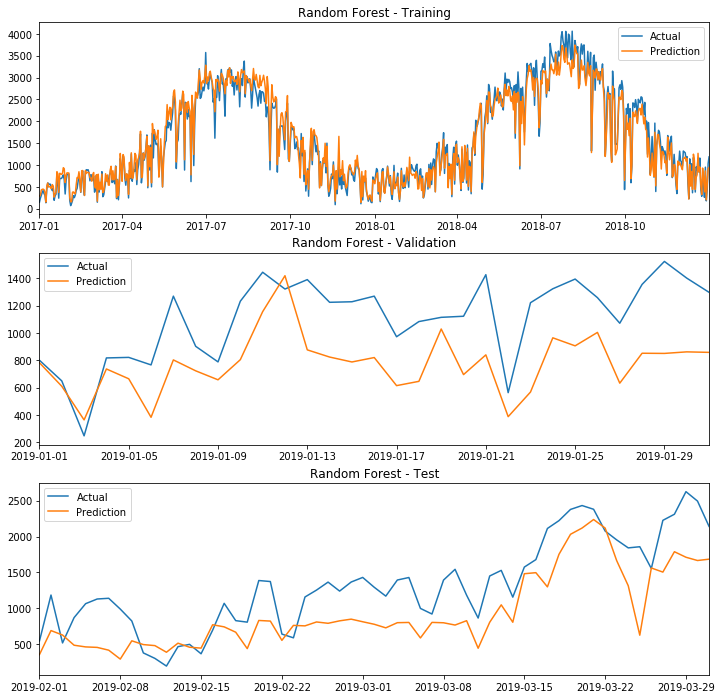

In [18]:
RF_y_pred_list = custom_predict(RF_model, X_train, X_valid, X_test, y_scaler=None)
RF_score = custom_model_score(RF_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(RF_score))
custom_plot_package('Random Forest', RF_y_pred_list, y_train, y_valid, y_test)

### XGBoost

In [19]:
from xgboost import XGBRegressor

XGB_model = XGBRegressor(learning_rate=.05, max_depth=4, 
                             n_estimators=200, gamma=0, 
                             subsample=0.9, colsample_bytree=0.7,
                             scale_pos_weight=1, min_child_weight=3,
                             reg_alpha=0.01)
XGB_model.fit(X_train, y_train)

[14:26:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=3, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.9, verbosity=1)

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,236.069992,377.174598,493.899273,0.947746,-0.606332,0.355502


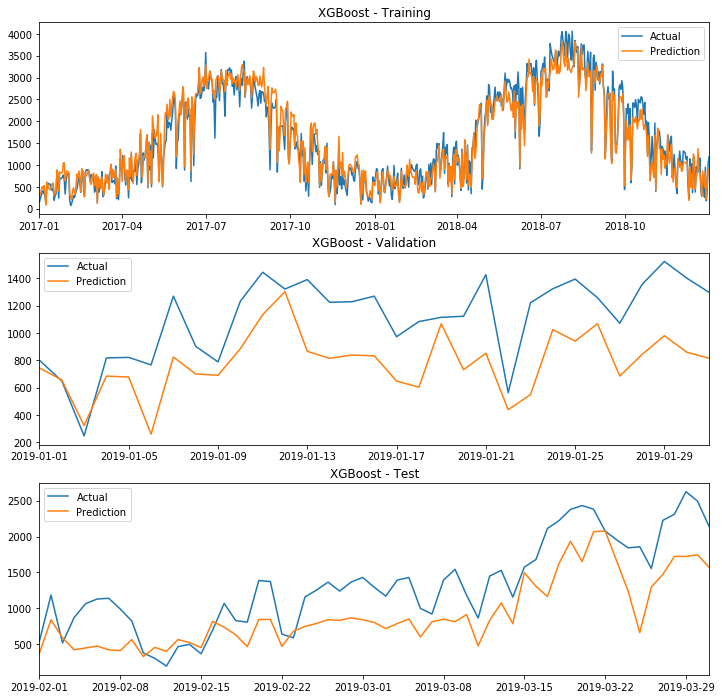

In [20]:
XGB_y_pred_list = custom_predict(XGB_model, X_train, X_valid, X_test, y_scaler=None)
XGB_score = custom_model_score(XGB_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(XGB_score))
custom_plot_package('XGBoost', XGB_y_pred_list, y_train, y_valid, y_test)

### LightGBM

In [21]:
from lightgbm import LGBMRegressor

LGBM_model = LGBMRegressor(learning_rate=0.1,
                           max_depth=3, 
                           n_estimators=302, 
                           num_leaves=6,
                           reg_alpha=94,
                           reg_lambda=92
                          )
LGBM_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=3,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=302, n_jobs=-1, num_leaves=6, objective=None,
       random_state=None, reg_alpha=94, reg_lambda=92, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,302.574415,386.498466,473.081048,0.914157,-0.686732,0.408689


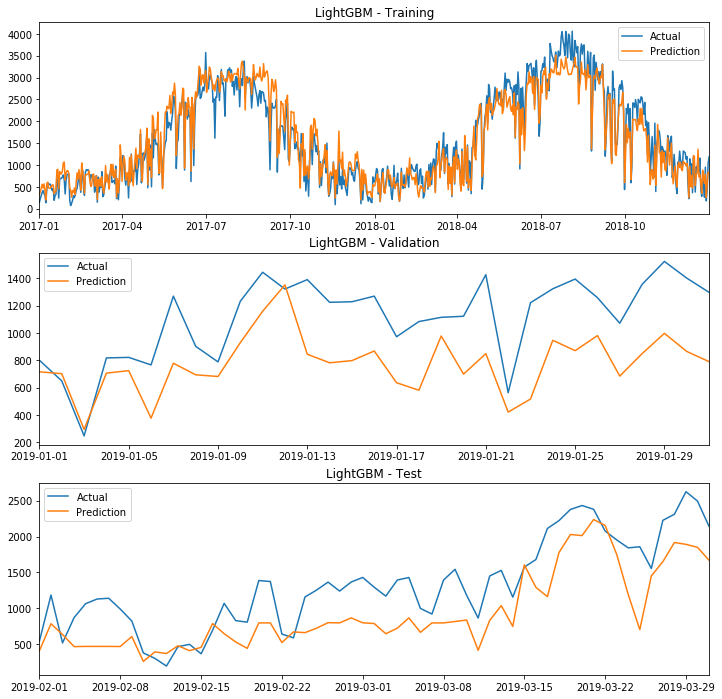

In [22]:
LGBM_y_pred_list = custom_predict(LGBM_model, X_train, X_valid, X_test, y_scaler=None)
LGBM_score = custom_model_score(LGBM_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(LGBM_score))
custom_plot_package('LightGBM', LGBM_y_pred_list, y_train, y_valid, y_test)

### CatBoost

In [23]:
from catboost import CatBoostRegressor
CB_model = CatBoostRegressor(learning_rate=0.01, 
                             max_depth=6, 
                             n_estimators=1500, 
                             l2_leaf_reg=4,
                             random_strength=0,
                             bagging_temperature=40,
                             task_type='GPU')

CB_model.fit(X_train, y_train, verbose=0)

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,478.56446,262.121124,375.74615,0.785256,0.224192,0.626978


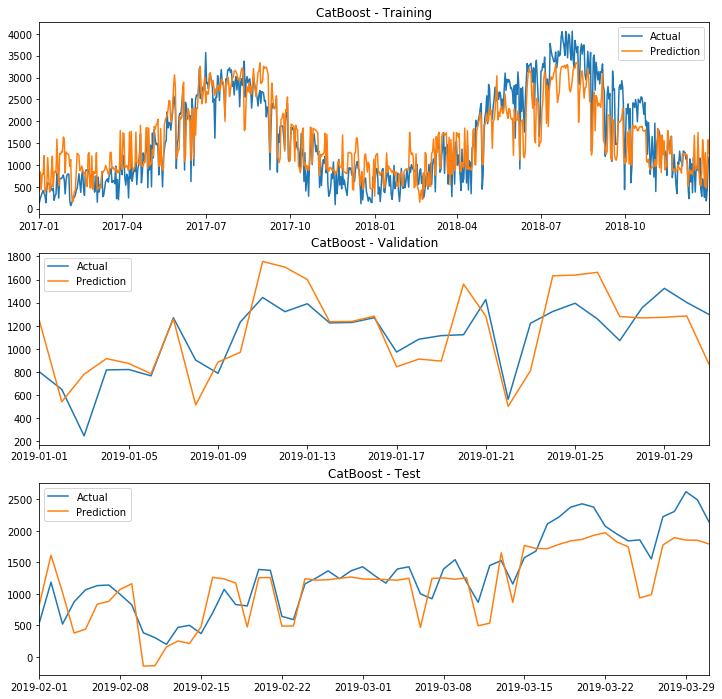

In [24]:
CB_y_pred_list = custom_predict(CB_model, X_train, X_valid, X_test, y_scaler=None)
CB_score = custom_model_score(CB_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(CB_score))
custom_plot_package('CatBoost', CB_y_pred_list, y_train, y_valid, y_test)

### Neural Network

In [25]:
from keras.models import Sequential
from keras.layers import Dense, RNN, LSTM, CuDNNLSTM, GRU, CuDNNGRU, Dropout, SimpleRNN, TimeDistributed, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [26]:
from sklearn.preprocessing import MinMaxScaler

x_scaler_NN = MinMaxScaler()
X_train_NN_scaled = x_scaler_NN.fit_transform(X_train)
X_valid_NN_scaled = x_scaler_NN.transform(X_valid)
X_test_NN_scaled = x_scaler_NN.transform(X_test)

y_scaler_NN = MinMaxScaler()
y_train_NN_scaled = y_scaler_NN.fit_transform(y_train.values.reshape(-1,1))
y_valid_NN_scaled = y_scaler_NN.transform(y_valid.values.reshape(-1,1))
y_test_NN_scaled = y_scaler_NN.transform(y_test.values.reshape(-1,1))

In [27]:
NN_model = Sequential()
NN_model.add(Dense(128, input_dim=X_train_NN_scaled.shape[1], activation='relu'))
NN_model.add(Dense(25, activation='relu'))
NN_model.add(Dense(1, activation='relu'))
NN_model.summary()

NN_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

history = NN_model.fit(X_train_NN_scaled, y_train_NN_scaled, epochs=100, verbose=0, batch_size=32, 
                       validation_data=(X_valid_NN_scaled, y_valid_NN_scaled), shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3072      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                3225      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 6,323
Trainable params: 6,323
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


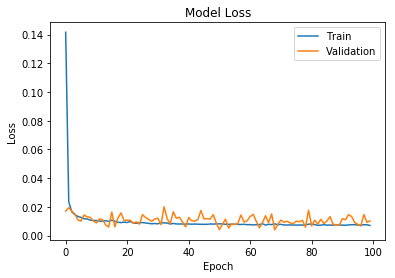

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show();

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,336.333072,404.153237,585.383012,0.893933,-0.844347,0.094632


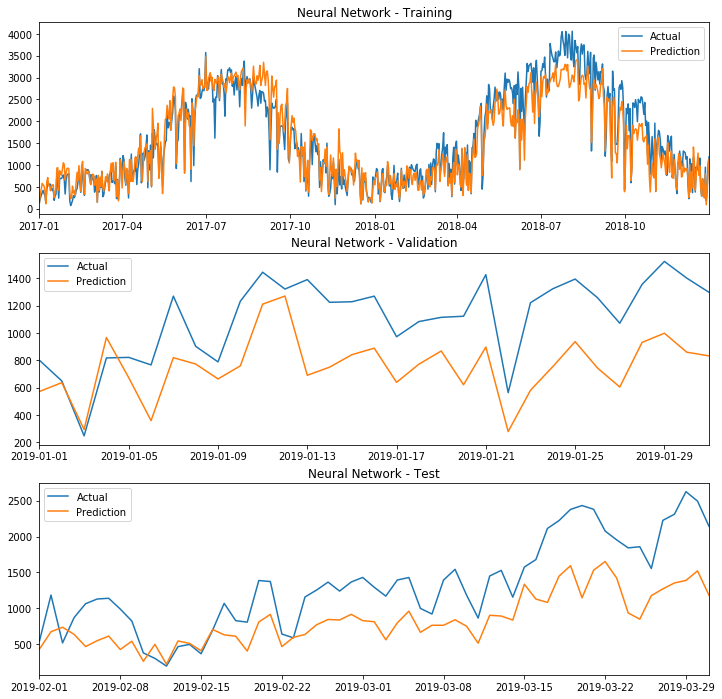

In [29]:
NN_y_pred_list = custom_predict(NN_model, X_train_NN_scaled, X_valid_NN_scaled, X_test_NN_scaled, y_scaler_NN)
NN_score = custom_model_score(NN_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(NN_score))
custom_plot_package('Neural Network', NN_y_pred_list, y_train, y_valid, y_test)

In [30]:
custom_score_display([lin_score, RF_score, XGB_score, LGBM_score, CB_score, NN_score], 
                     index=['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'Neural Network'])

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
Linear Regression,404.757259,421.274793,558.745766,0.846386,-1.003925,0.175153
Random Forest,186.321287,388.738074,483.781538,0.967449,-0.706336,0.381637
XGBoost,236.069992,377.174598,493.899273,0.947746,-0.606332,0.355502
LightGBM,302.574415,386.498466,473.081048,0.914157,-0.686732,0.408689
CatBoost,478.564460,262.121124,375.746150,0.785256,0.224192,0.626978
Neural Network,336.333072,404.153237,585.383012,0.893933,-0.844347,0.094632


##  Composition Model

After trying different combinations of prediction outputs from our models, one combination appeared to be fairly robust. This consisted of the average of: 2 times the output of XGBoost, 1 times the output of CatBoost and 1 times the output of a Neural Network.

\begin{equation*}
\hat{y}_{Composition Model} = \frac {2\hat{y}_{XGBoost} + \hat{y}_{CatBoost} + \hat{y}_{Neural Network}}{3}
\end{equation*}

I decided to multiply the result of XGBoost by two because this gradient boosting model appeared to model the fluctuations fairly well in the validation and testing set and it was only under predicting the outputs. This lead me to include a different gradient boosting method, CatBoost, to my composition model to average out the effects of XGBoost. In addition, the model that I tuned followed the trend well and forecasted the fluctuations well. However, it wasn't accurate on predicting the values. I included the predicted values of a Neural Network to give the composition model some stability in the outputs. The three different models all have different characteristics.

In [31]:
def predict_composition_model(index_list):
    
    '''
    Best model average
    '''
    
    output_df = []
    
    for i in range(3):
        out_y_predictors = pd.DataFrame({
                                'XGBoost': XGB_y_pred_list[i]*2,
                                'CatBoost': CB_y_pred_list[i],
                                'Neural Network': NN_y_pred_list[i].reshape(1, NN_y_pred_list[i].shape[0])[0],
                                 })
        
        df_avg = pd.DataFrame({'Value': out_y_predictors.mean(axis=1)})
        df_avg.index = index_list[i]
        output_df.append(df_avg)
        
    return output_df

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
0,631.781041,195.433266,254.420978,0.62574,0.568732,0.828978


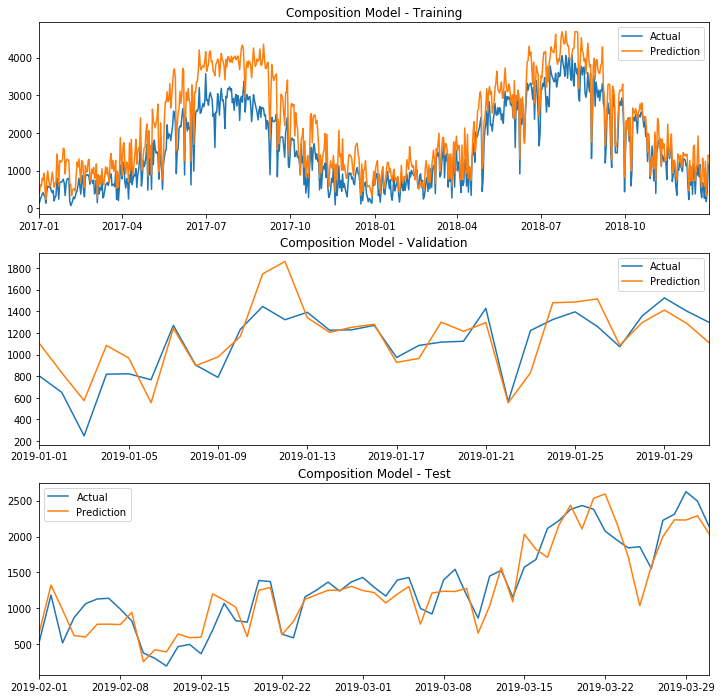

In [32]:
best_model_y_pred_list = predict_composition_model(index_list=[X_train.index, X_valid.index, X_test.index])
best_model_score = custom_model_score(best_model_y_pred_list, y_train, y_valid, y_test)
display(custom_score_display(best_model_score))
custom_plot_package('Composition Model', best_model_y_pred_list, y_train, y_valid, y_test)

In [33]:
custom_score_display([lin_score, RF_score, XGB_score, LGBM_score, CB_score, NN_score, best_model_score], 
                     index=['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'Neural Network', 'Composition Model'])

,Training - RMSE,Validation - RMSE,Test - RMSE,Training - R2,Valid - R2,Test - R2
Linear Regression,404.757259,421.274793,558.745766,0.846386,-1.003925,0.175153
Random Forest,186.321287,388.738074,483.781538,0.967449,-0.706336,0.381637
XGBoost,236.069992,377.174598,493.899273,0.947746,-0.606332,0.355502
LightGBM,302.574415,386.498466,473.081048,0.914157,-0.686732,0.408689
CatBoost,478.564460,262.121124,375.746150,0.785256,0.224192,0.626978
Neural Network,336.333072,404.153237,585.383012,0.893933,-0.844347,0.094632
Composition Model,631.781041,195.433266,254.420978,0.625740,0.568732,0.828978


## Backtesting the Model

To test the stability of the model parameters, I have done a backtest where I recorded the RMSE of the following 1 month with a model trained with all avaiable preceeding data. I iterated through January 2018 to March 2019 for the predictions. eg. Predicted the bike count of January 2018 with a model trained with data from January to December 2017.

The result is that the Composition Model was the most stable with the lowest RMSE score throughout the iteration period.

In [34]:
from dateutil.relativedelta import *

output_score = []

start_date = datetime.date(2018, 1, 1)
end_date = datetime.date(2017, 12, 31)

for i in range(0,15):
    print(i)
    date_range_train = pd.date_range(start=datetime.date(2017, 1, 1), end=end_date, freq='D')
    date_range_valid = pd.date_range(start=start_date, end=(end_date + relativedelta(months=+1)), freq='D')
    date_range_test = pd.date_range(start=start_date, end=(end_date + relativedelta(months=+1)), freq='D')
                         
    start_date += relativedelta(months=+1)
    end_date += relativedelta(months=+1)
    
    X_onehot = pd.get_dummies(X)
    X_train, X_valid,  X_test = custom_tvt_split(X_onehot, date_range_train, date_range_valid, date_range_test)
    
    y_train, y_valid,  y_test = custom_tvt_split(y, date_range_train, date_range_valid, date_range_test)
    
    import statsmodels.api as sm
    X_onehot_c = sm.add_constant(X_onehot)
    X_train_c, X_valid_c,  X_test_c = custom_tvt_split(X_onehot_c, date_range_train, date_range_valid, date_range_test)
    
    
    #=== Linear Regression
    lin_reg_model_sm = linear_model.OLS(y_train, X_train_c).fit()
    lin_y_pred_list = custom_predict(lin_reg_model_sm, X_train_c, X_valid_c, X_test_c)
    lin_score = custom_model_score(lin_y_pred_list, y_train, y_valid, y_test)
    
    #=== Random Forest
    RF_model.fit(X_train, y_train)
    RF_y_pred_list = custom_predict(RF_model, X_train, X_valid, X_test)
    RF_score = custom_model_score(RF_y_pred_list, y_train, y_valid, y_test)
    
    #=== XGBoost
    XGB_model.fit(X_train, y_train)
    XGB_y_pred_list = custom_predict(XGB_model, X_train, X_valid, X_test)
    XGB_score = custom_model_score(XGB_y_pred_list, y_train, y_valid, y_test)
    
    #=== LightGBM
    LGBM_model.fit(X_train, y_train)
    LGBM_y_pred_list = custom_predict(LGBM_model, X_train, X_valid, X_test)
    LGBM_score = custom_model_score(LGBM_y_pred_list, y_train, y_valid, y_test)
    
    #=== CatBoost
    CB_model.fit(X_train, y_train, verbose=False)
    CB_y_pred_list = custom_predict(CB_model, X_train, X_valid, X_test)
    CB_score = custom_model_score(CB_y_pred_list, y_train, y_valid, y_test)
    
    #=== Neural Network
    
    from sklearn.preprocessing import MinMaxScaler

    x_scaler_NN = MinMaxScaler()
    X_train_NN_scaled = x_scaler_NN.fit_transform(X_train)
    X_valid_NN_scaled = x_scaler_NN.transform(X_valid)
    X_test_NN_scaled = x_scaler_NN.transform(X_test)

    y_scaler_NN = MinMaxScaler()
    y_train_NN_scaled = y_scaler_NN.fit_transform(y_train.values.reshape(-1,1))
    y_valid_NN_scaled = y_scaler_NN.transform(y_valid.values.reshape(-1,1))
    y_test_NN_scaled = y_scaler_NN.transform(y_test.values.reshape(-1,1))
    
    history = NN_model.fit(X_train_NN_scaled, y_train_NN_scaled, epochs=100, verbose=0, batch_size=32, 
                       validation_data=(X_valid_NN_scaled, y_valid_NN_scaled), shuffle=True)

    NN_y_pred_list = custom_predict(NN_model, X_train_NN_scaled, X_valid_NN_scaled, X_test_NN_scaled, y_scaler_NN)
    NN_score = custom_model_score(NN_y_pred_list, y_train, y_valid, y_test)

    #===
    
    best_model_y_pred_list = predict_composition_model(index_list=[X_train.index, X_valid.index, X_test.index])
    best_model_score = custom_model_score(best_model_y_pred_list, y_train, y_valid, y_test)
    
    scores = custom_score_display([best_model_score, lin_score, RF_score, XGB_score, LGBM_score, CB_score, NN_score], 
                     index=['Composition Model', 'Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'Neural Network']).iloc[:,2]

    output_score.append(scores)

0
[14:26:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


1
[14:27:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


2
[14:27:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


3
[14:28:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


4
[14:28:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


5
[14:29:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


6
[14:29:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


7
[14:29:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


8
[14:30:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


9
[14:30:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


10
[14:30:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


11
[14:31:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


12
[14:31:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


13
[14:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


14
[14:32:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


''

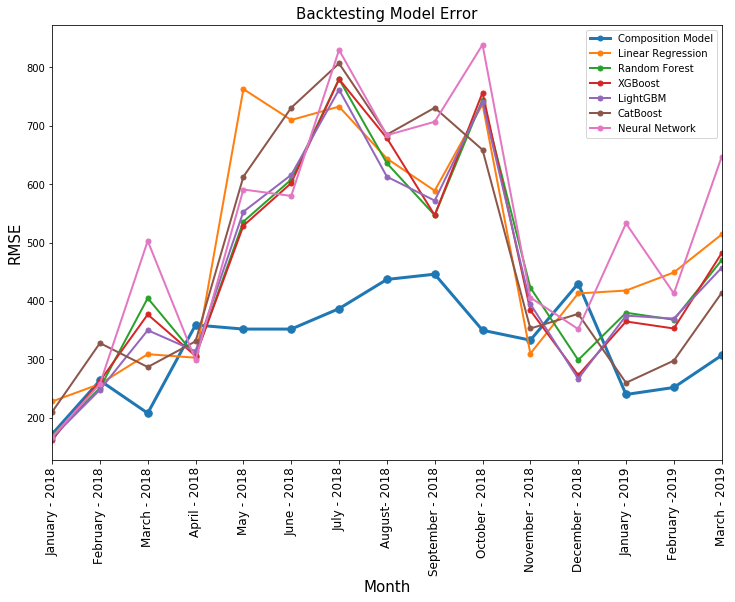

In [53]:
output = pd.concat(output_score, axis=1)
month_label = ['January - 2018', 'February - 2018', 'March - 2018', 'April - 2018', 'May - 2018', 'June - 2018', \
                  'July - 2018', 'August- 2018', 'September - 2018', 'October - 2018', 'November - 2018', 'December - 2018', \
                  'January - 2019', 'February -2019', 'March - 2019']

output.columns = month_label


font_size_tick = 12
ax = output.transpose().round().plot(figsize=(12,8), style='.-', markersize=10)
ax.set_xlabel('Month', size=15)
ax.set_ylabel('RMSE', size=15)
ax.set_title('Backtesting Model Error', size=15)
ax.set_xticks(range(0,len(month_label)), minor=False)
ax.set_xticklabels(month_label, fontsize=font_size_tick, rotation=90)
leg = ax.legend()


lws = [3] + [2]*6
mks = [15] + [10]*6
for i, l in enumerate(ax.lines):
    plt.setp(l, linewidth=lws[i], markersize=mks[i])

for i, line in enumerate(leg.get_lines()):
    line.set_linewidth(lws[i])
    line.set_markersize(mks[i])
;

In [36]:
output.transpose().round()

,Composition Model,Linear Regression,Random Forest,XGBoost,LightGBM,CatBoost,Neural Network
January - 2018,172.0,228.0,169.0,162.0,166.0,210.0,167.0
February - 2018,264.0,258.0,251.0,263.0,248.0,328.0,258.0
March - 2018,208.0,309.0,405.0,377.0,350.0,287.0,503.0
April - 2018,359.0,303.0,306.0,306.0,314.0,331.0,299.0
May - 2018,352.0,763.0,536.0,529.0,553.0,613.0,591.0
June - 2018,352.0,710.0,608.0,602.0,616.0,731.0,580.0
July - 2018,387.0,733.0,780.0,780.0,762.0,807.0,830.0
August- 2018,437.0,644.0,636.0,679.0,613.0,685.0,684.0
September - 2018,446.0,589.0,547.0,547.0,572.0,731.0,707.0
October - 2018,350.0,737.0,745.0,757.0,741.0,659.0,839.0
